#### library

In [1]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.api import VAR
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import xgboost as xgb
import catboost as cb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim
from layers.autoformer_encdec import series_decomp, series_decomp_multi, moving_avg
from layers.autoformer_encdec import series_decomp_fixed, series_decomp_fixed_multi

print(torch.__version__)

2.4.1+cu121


#### data load

In [158]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [159]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")

100%|██████████| 107/107 [00:02<00:00, 37.97it/s]


#### data engineering

In [160]:
# missing value check

train_df = df.loc[df["_type"] == "train"]
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [161]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)

In [162]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [163]:

test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [164]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [165]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing, errors='ignore')

In [166]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [167]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

In [168]:
'''
features_to_scale = [col for col in cleaned_train_df.columns if col not in ['ID', 'target', '_type']]

scaler = StandardScaler()

# 훈련 데이터 정규화
train_df_scaled = cleaned_train_df.copy()
train_df_scaled[features_to_scale] = scaler.fit_transform(cleaned_train_df[features_to_scale])

# 테스트 데이터 정규화
test_df_scaled = cleaned_test_df.copy()
test_df_scaled[features_to_scale] = scaler.transform(cleaned_test_df[features_to_scale])


# 함수 호출
std_train_df = train_df_scaled
std_test_df = test_df_scaled
'''

"\nfeatures_to_scale = [col for col in cleaned_train_df.columns if col not in ['ID', 'target', '_type']]\n\nscaler = StandardScaler()\n\n# 훈련 데이터 정규화\ntrain_df_scaled = cleaned_train_df.copy()\ntrain_df_scaled[features_to_scale] = scaler.fit_transform(cleaned_train_df[features_to_scale])\n\n# 테스트 데이터 정규화\ntest_df_scaled = cleaned_test_df.copy()\ntest_df_scaled[features_to_scale] = scaler.transform(cleaned_test_df[features_to_scale])\n\n\n# 함수 호출\nstd_train_df = train_df_scaled\nstd_test_df = test_df_scaled\n"

#### stationarity

In [65]:
def stationarity_test(timeseries, pvalue = .01, regression_option = 'ct'):
    # print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    adf_count = 0
    kpss_count = 0

    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    # print (dfoutput)
    if dfoutput[1] < pvalue:
        # print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
        adf_count += 1

    else:
        # print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")
        adf_count += 0
    # print('--'*40)
    # print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    # print (kpss_output)
    if kpss_output[1] < pvalue:
        # print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
        kpss_count += 0
    else:
        # print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")
        kpss_count += 1
    return adf_count, kpss_count
    

In [77]:
sta_count = 0
non_sta_count = 0
adf_sta_count = 0
kpss_sta_count = 0
non_station_col = []
for col in std_train_df.columns[3:]:
    if stationarity_test(std_train_df[col]) == (1,1):
        sta_count += 1
    elif stationarity_test(std_train_df[col]) == (0,0):
        non_sta_count += 1
    elif stationarity_test(std_train_df[col]) == (1,0):
        adf_sta_count += 1
    else:
        kpss_sta_count += 1
        non_station_col.append(col)


In [78]:
non_station_col

['hourly_network-data_difficulty_difficulty',
 'hourly_market-data_open-interest_deribit_btc_usd_open_interest',
 'hourly_market-data_open-interest_deribit_all_symbol_open_interest',
 'hourly_market-data_open-interest_huobi_global_btc_usdt_open_interest',
 'hourly_market-data_open-interest_bybit_all_symbol_open_interest',
 'hourly_market-data_open-interest_bitfinex_all_symbol_open_interest',
 'hourly_market-data_open-interest_okx_btc_usd_open_interest',
 'hourly_market-data_open-interest_huobi_global_btc_usd_open_interest',
 'hourly_market-data_open-interest_kraken_btc_usd_open_interest',
 'hourly_market-data_open-interest_kraken_all_symbol_open_interest',
 'hourly_market-data_open-interest_binance_btc_usdt_open_interest',
 'hourly_market-data_open-interest_binance_btc_usd_open_interest',
 'hourly_market-data_open-interest_huobi_global_all_symbol_open_interest',
 'hourly_market-data_open-interest_bybit_btc_usdt_open_interest',
 'hourly_market-data_open-interest_okx_all_symbol_open_inte

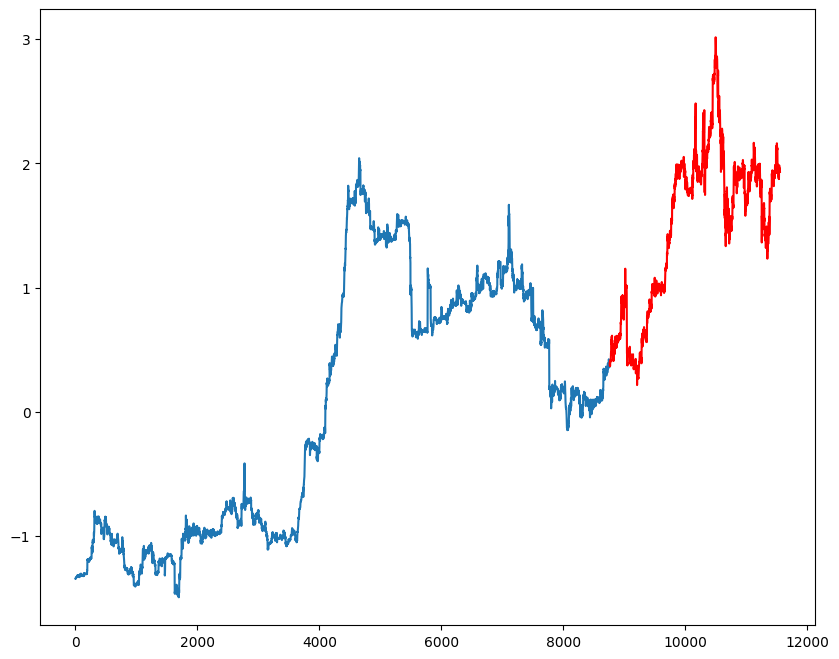

In [118]:
plt.figure(figsize=(10,8))
col = 'hourly_market-data_open-interest_bitfinex_all_symbol_open_interest'
plt.plot(std_train_df.index, std_train_df[col].values)
plt.plot(std_test_df.index, std_test_df[col].values, c = 'r')

plt.show()

#### price(종가) 예측 - arima

In [49]:
# 타겟과 피처 설정
price_data = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
price_data.head(3)

0   -2.083215
1   -2.079750
2   -2.081277
Name: hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close, dtype: float64

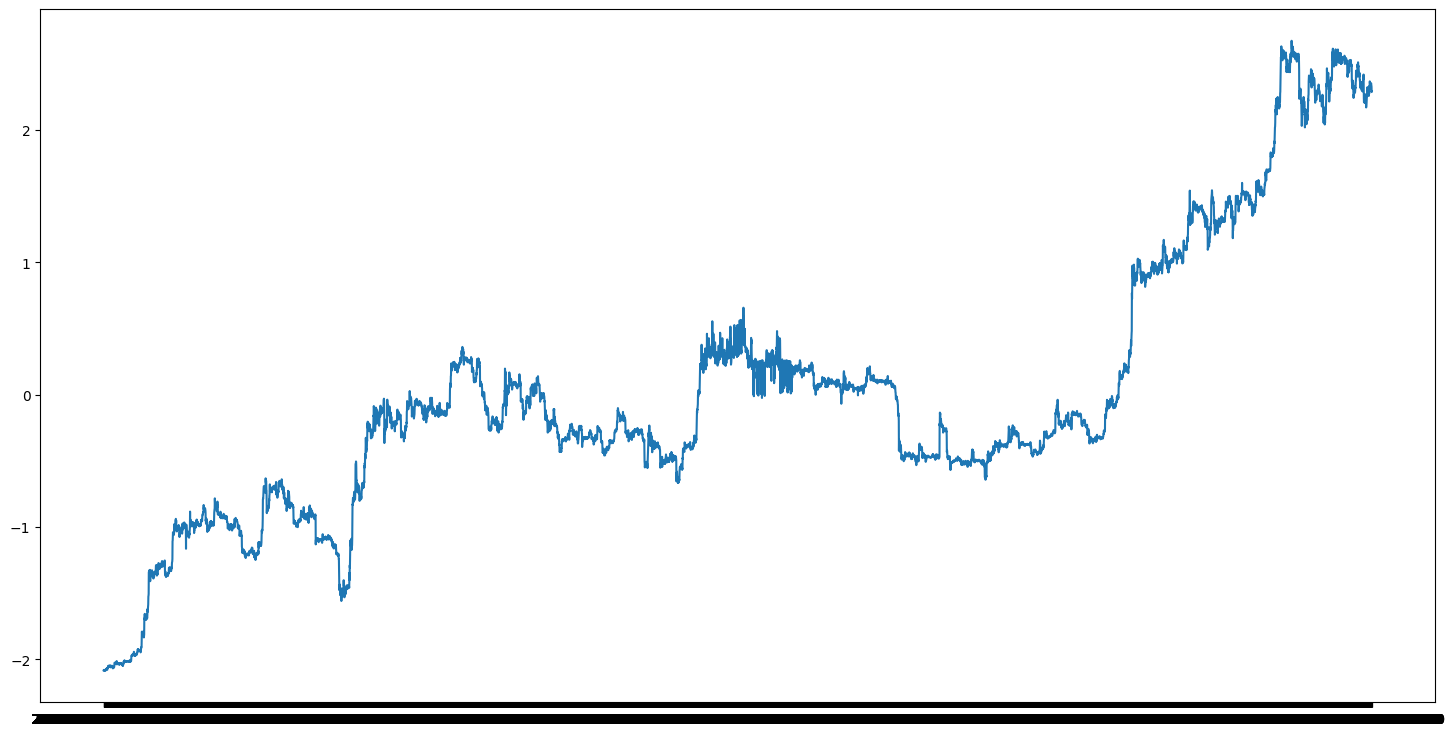

In [13]:
plt.figure(figsize=(18,9))
plt.plot(std_train_df['ID'], std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'], linestyle="-")
plt.xlabel=('Day')
plt.ylabel=('Price')
plt.show()

In [51]:
def adf_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC', regression = regression_option)
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dfoutput[1] < pvalue:
        print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성이 보장됩니다.")
    else:
        print(f"정상시계열이 아니라는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.")

# adf 함수를 통해 출력
adf_test(price_data)

Results of Dickey-Fuller Test:
Test Statistic                   -1.723646
p-value                           0.740361
Lags Used                        37.000000
Number of Observations Used    8722.000000
Critical Value (1%)              -3.959808
Critical Value (5%)              -3.410993
Critical Value (10%)             -3.127346
dtype: float64
정상시계열이 아니라는 귀무가설을 5.0%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성을 보장하지 못합니다.


In [52]:
def kpss_test(timeseries, pvalue = .05, regression_option = 'ct'):
    print ('Results of KPSS Test:')
    kpsstest = kpss(timeseries, regression= regression_option)
    kpss_output = pd.Series(kpsstest[0:3], index=['Test Statistic','p-value','Lags Used'])
    for key,value in kpsstest[3].items():
        kpss_output['Critical Value (%s)'%key] = value
    print (kpss_output)
    if kpss_output[1] < pvalue:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.")
    else:
        print(f"정상시계열이 맞다는 귀무가설을 {pvalue*100}%의 유의수준으로 기각할 수 없으므로 해당 데이터는 정상성이 보장됩니다.")
        
kpss_test(price_data)

Results of KPSS Test:
Test Statistic            1.506183
p-value                   0.010000
Lags Used                56.000000
Critical Value (10%)      0.119000
Critical Value (5%)       0.146000
Critical Value (2.5%)     0.176000
Critical Value (1%)       0.216000
dtype: float64
정상시계열이 맞다는 귀무가설을 5.0%의 유의수준으로 기각할 수 있으므로 해당 데이터는 정상성을 보장하지 못합니다.


/tmp/ipykernel_795625/2586163831.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpsstest = kpss(timeseries, regression= regression_option)


In [53]:
model_arima= auto_arima(price_data,trace=True, error_action='ignore', start_p=1,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(price_data)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-35596.013, Time=0.41 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-36281.014, Time=1.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-36315.404, Time=2.35 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-36333.813, Time=0.66 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-36329.520, Time=0.37 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-36327.623, Time=2.04 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-36328.497, Time=1.95 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-36330.395, Time=1.43 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-36327.610, Time=0.56 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-36325.519, Time=2.44 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-36334.898, Time=5.23 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-36331.117, Time=4.38 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-36329.078, Time=0.47 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-36328.030, Time=1.63 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-36325

ARIMA(order=(2, 1, 2), scoring_args={}, suppress_warnings=True)

In [54]:
# log 변환 방법
log_df = np.log(price_data+3) # 로그 변환(-2 값부터 있었기 때문에 3을 더해줬음. 추후에 예측된 값에서 np.exp와 -3을 실시해야할 것)
log_price_df = log_df.diff(1).dropna() # 1차 차분

In [55]:
print("ACF 값 : {0}".format(sm.tsa.stattools.acf(log_price_df, nlags=10, fft=False)))
print("PACF 값 : {0}".format(sm.tsa.stattools.pacf(log_price_df, nlags=10, method='ywm')))

ACF 값 : [ 1.00000000e+00 -2.45319291e-01  7.07886262e-02 -2.83405943e-02
  1.11884809e-02 -3.62764858e-02  1.76111618e-02  2.66132089e-04
  4.04224692e-03  4.35861059e-03  1.73066491e-02]
PACF 값 : [ 1.00000000e+00 -2.45319291e-01  1.12862985e-02 -8.94119301e-03
  1.57344308e-03 -3.43905387e-02  5.62909919e-04  7.79680283e-03
  4.78569347e-03  6.63572368e-03  1.98215022e-02]


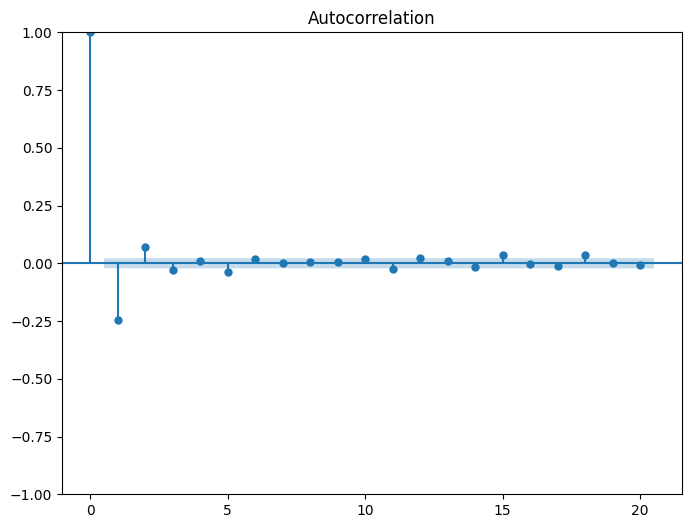

In [56]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_acf(log_price_df, lags=20, ax=ax)
plt.show()

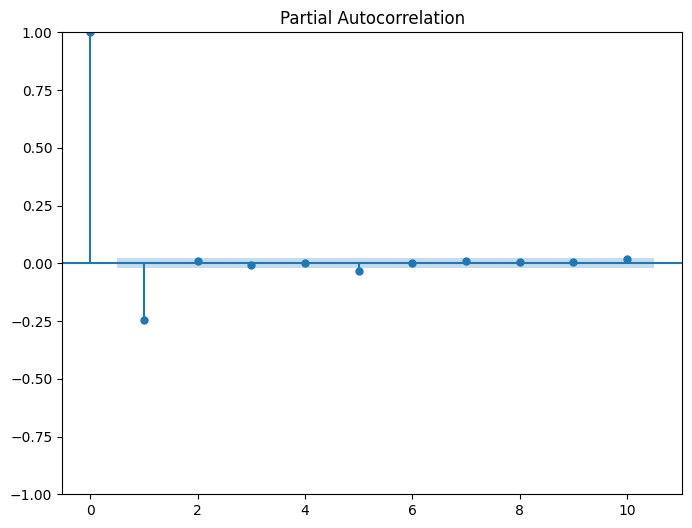

In [57]:
fig = plt.figure(figsize=(8,6))
fig.set_facecolor('white')
ax = fig.add_subplot()
sm.graphics.tsa.plot_pacf(log_price_df, lags=10, ax=ax)
plt.show()

In [58]:
model_arima= auto_arima(log_df,trace=True, error_action='ignore',d = 1, start_p=2,start_q=1,max_p=3,max_q=3,suppress_warnings=True,stepwise=False,seasonal=False)
model_arima.fit(log_df)

 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-54689.509, Time=0.45 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-55191.496, Time=0.41 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-55224.454, Time=0.83 sec
 ARIMA(0,1,3)(0,0,0)[0] intercept   : AIC=-55228.753, Time=1.62 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-55231.113, Time=0.42 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-55230.308, Time=1.17 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-55229.386, Time=0.84 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=-55227.078, Time=0.95 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-55230.229, Time=1.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-55231.478, Time=1.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-55224.959, Time=3.66 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=-55225.360, Time=1.95 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=-55228.928, Time=1.09 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=-55226.957, Time=1.78 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=-55224

ARIMA(order=(2, 1, 1), scoring_args={}, suppress_warnings=True)

In [59]:
print(model_arima.summary())

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 8760
Model:               SARIMAX(2, 1, 1)   Log Likelihood               27620.739
Date:                Thu, 26 Sep 2024   AIC                         -55231.478
Time:                        11:33:13   BIC                         -55196.088
Sample:                             0   HQIC                        -55219.419
                               - 8760                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.0004      0.000      2.187      0.029    4.45e-05       0.001
ar.L1         -0.9958      0.131     -7.580      0.000      -1.253      -0.738
ar.L2         -0.1732      0.035     -4.956      0.0

In [62]:
# 4개월(2880시간) 예측
forecast_steps = 2880  # 4개월치

model = sm.tsa.arima.ARIMA(log_df, order = (2,1,1))
model_fit = model.fit()
forecast_df = model_fit.forecast(steps=forecast_steps)

In [63]:
forecast_df

8760     1.665884
8761     1.666005
8762     1.665937
8763     1.665982
8764     1.665950
           ...   
11635    1.665963
11636    1.665963
11637    1.665963
11638    1.665963
11639    1.665963
Name: predicted_mean, Length: 2880, dtype: float64

In [64]:
price_pred = np.exp(forecast_df)-3
price_pred.shape

(2880,)

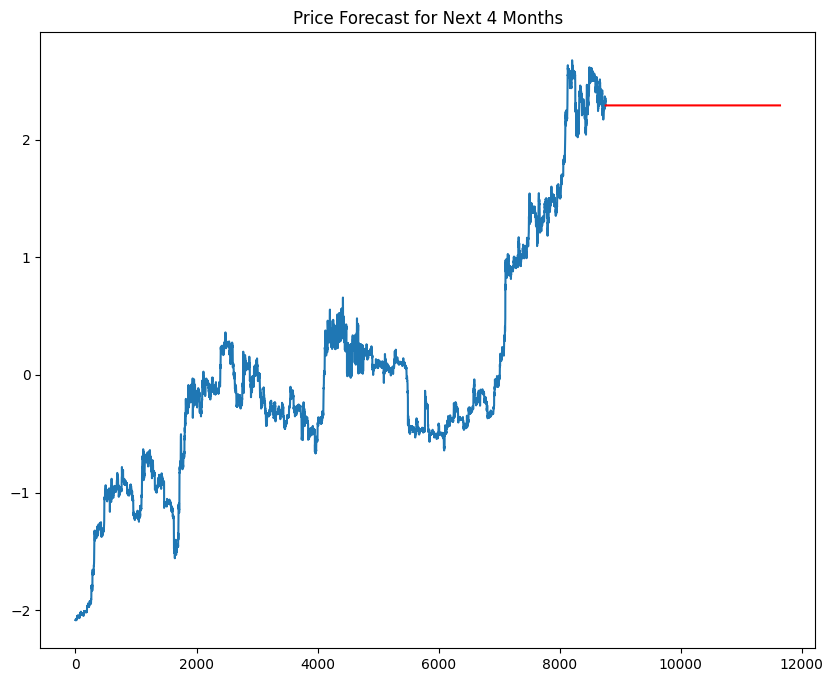

In [65]:
forecast_step = 2880

plt.figure(figsize=(10,8))
plt.plot(price_data, label='Historical Data')
plt.plot(range(price_data.index[-1]+1, price_data.index[-1]+1 + len(price_pred)), price_pred, label='Forecast', color='red')
plt.title('Price Forecast for Next 4 Months')
plt.show()

#### price 예측 (deep learning model)

In [111]:
class Model(nn.Module):
    def __init__(self, configs, individual=False):
        super(Model, self).__init__()
        self.seq_len = configs['seq_len']
        self.pred_len = configs['pred_len']
        # Series decomposition block from Autoformer
        self.decompsition = series_decomp(configs['moving_avg'])
        self.individual = individual
        self.channels = configs['enc_in']

        if self.individual:
            self.Linear_Seasonal = nn.ModuleList()
            self.Linear_Trend = nn.ModuleList()

            for i in range(self.channels):
                self.Linear_Seasonal.append(
                    nn.Linear(self.seq_len, self.pred_len))
                self.Linear_Trend.append(
                    nn.Linear(self.seq_len, self.pred_len))

                self.Linear_Seasonal[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
                self.Linear_Trend[i].weight = nn.Parameter(
                    (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
        else:
            self.Linear_Seasonal = nn.Linear(self.seq_len, self.pred_len)
            self.Linear_Trend = nn.Linear(self.seq_len, self.pred_len)

            self.Linear_Seasonal.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))
            self.Linear_Trend.weight = nn.Parameter(
                (1 / self.seq_len) * torch.ones([self.pred_len, self.seq_len]))

    def encoder(self, x):
        seasonal_init, trend_init = self.decompsition(x)
        seasonal_init, trend_init = seasonal_init.permute(
            0, 2, 1), trend_init.permute(0, 2, 1)
        if self.individual:
            seasonal_output = torch.zeros([seasonal_init.size(0), seasonal_init.size(1), self.pred_len],
                                          dtype=seasonal_init.dtype).to(seasonal_init.device)
            trend_output = torch.zeros([trend_init.size(0), trend_init.size(1), self.pred_len],
                                       dtype=trend_init.dtype).to(trend_init.device)
            for i in range(self.channels):
                seasonal_output[:, i, :] = self.Linear_Seasonal[i](
                    seasonal_init[:, i, :])
                trend_output[:, i, :] = self.Linear_Trend[i](
                    trend_init[:, i, :])
        else:
            seasonal_output = self.Linear_Seasonal(seasonal_init)
            trend_output = self.Linear_Trend(trend_init)
        x = seasonal_output + trend_output
        return x.permute(0, 2, 1)

    def forecast(self, x_enc):
        # Encoder
        return self.encoder(x_enc)
    
    def forward(self, x_enc):
        dec_out = self.forecast(x_enc)
        return dec_out[:, -self.pred_len:, :]  # [B, L, D]

In [147]:
train_y = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
train_X = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

In [148]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [149]:
# 시퀀스 길이와 예측 길이
seq_len = 24  # 24시간(1일)치 데이터를 사용해 예측한다고 가정
pred_len = 1  # 1시간 후의 값을 예측
batch_size = 128

# 데이터를 슬라이딩 윈도우 방식으로 시퀀스로 변환
def create_sequences(data_X, data_y, seq_len, pred_len):
    X, y = [], []
    for i in range(len(data_X) - seq_len - pred_len):
        X.append(data_X.iloc[i:i+seq_len].values)
        y.append(data_y.iloc[i+seq_len:i+seq_len+pred_len].values)
    return torch.tensor(X, dtype=torch.float32), torch.tensor(y, dtype=torch.float32)


# 3. 시퀀스 생성
train_X, train_y = create_sequences(train_X, train_y, seq_len, pred_len)

# 4. Train과 Validation 데이터로 분할
split_idx = int(len(train_X) * 0.8)  # 80%를 training set으로, 20%를 validation set으로

X_train, y_train = train_X[:split_idx], train_y[:split_idx]
X_valid, y_valid = train_X[split_idx:], train_y[split_idx:]

# 5. DataLoader 생성
train_dataset = TensorDataset(X_train, y_train)
valid_dataset = TensorDataset(X_valid, y_valid)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False)

In [150]:
# Config 설정
configs = {
    'seq_len': 24,      # 24시간 시계열 데이터를 사용
    'pred_len': 1,      # 1시간 후의 price 예측
    'moving_avg': 13,   # 이동평균을 위한 설정값
    'enc_in': 205       # 피처의 개수
}
# Hyperparameters
learning_rate = 0.001
num_epochs = 100

model = Model(configs,individual=False).to(device)

In [151]:
# Define Loss Function and Optimizer
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [152]:
train_losses = []
valid_losses = []

for epoch in range(num_epochs+1):
    # Training phase
    model.train()
    total_train_loss = 0
    for batch_X, batch_y in train_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 장치로 이동
        optimizer.zero_grad()
        output = model(batch_X)  # 모델의 예측값
        loss = criterion(output, batch_y)  # MSE 계산
        loss.backward()  # Backpropagation
        optimizer.step()  # Weight update
        
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validation phase
    model.eval()
    total_valid_loss = 0
    with torch.no_grad():  # Gradients 계산하지 않음
        for batch_X, batch_y in valid_loader:
            batch_X, batch_y = batch_X.to(device), batch_y.to(device)  # 데이터를 장치로 이동
            output = model(batch_X)
            loss = criterion(output, batch_y)
            total_valid_loss += loss.item()

    avg_valid_loss = total_valid_loss / len(valid_loader)
    valid_losses.append(avg_valid_loss)

    # Epoch 결과 출력
    if epoch % 10 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}, Valid Loss: {avg_valid_loss:.4f}')

Epoch [1/100], Train Loss: 0.5418, Valid Loss: 3.1513
Epoch [11/100], Train Loss: 0.2959, Valid Loss: 4.6530
Epoch [21/100], Train Loss: 0.2950, Valid Loss: 4.6714
Epoch [31/100], Train Loss: 0.2955, Valid Loss: 4.6595
Epoch [41/100], Train Loss: 0.2953, Valid Loss: 4.6766
Epoch [51/100], Train Loss: 0.2948, Valid Loss: 4.6530
Epoch [61/100], Train Loss: 0.2953, Valid Loss: 4.6601
Epoch [71/100], Train Loss: 0.2957, Valid Loss: 4.6515
Epoch [81/100], Train Loss: 0.2953, Valid Loss: 4.6405
Epoch [91/100], Train Loss: 0.2952, Valid Loss: 4.6621
Epoch [101/100], Train Loss: 0.2957, Valid Loss: 4.6483


#### lstm

In [39]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

In [40]:
df = pd.concat([X_train, y_train], axis=1)

In [41]:
# 7일간의 데이터가 입력으로 들어가고 batch size는 임의로 지정
seq_length = 24
batch = 128

# 전체 데이터의 80% 학습, 20% 테스트에 사용
train_size = int(len(df)*0.8)
train_set = df[0:train_size]  
test_set = df[train_size-seq_length:]

In [42]:
# 데이터셋 생성 함수
def build_dataset(time_series, seq_length):
    dataX = []
    dataY = []
    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i+seq_length, :]
        _y = time_series[i+seq_length, [-1]]
        # print(_x, "-->",_y)
        dataX.append(_x)
        dataY.append(_y)

    return np.array(dataX), np.array(dataY)

trainX, trainY = build_dataset(np.array(train_set), seq_length)
testX, testY = build_dataset(np.array(test_set), seq_length)

# 텐서로 변환
trainX_tensor = torch.FloatTensor(trainX)
trainY_tensor = torch.FloatTensor(trainY)

testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

# 텐서 형태로 데이터 정의
dataset = TensorDataset(trainX_tensor, trainY_tensor)

# 데이터로더는 기본적으로 2개의 인자를 입력받으며 배치크기는 통상적으로 2의 배수를 사용
dataloader = DataLoader(dataset,
                        batch_size=batch,
                        shuffle=True,  
                        drop_last=True)

In [43]:
# 설정값
data_dim = 206 # column length
hidden_dim = 10 
output_dim = 1 
learning_rate = 0.01
nb_epochs = 100

class Net(nn.Module):
    # # 기본변수, layer를 초기화해주는 생성자
    def __init__(self, input_dim, hidden_dim, seq_len, output_dim, layers):
        super(Net, self).__init__()
        self.hidden_dim = hidden_dim
        self.seq_len = seq_len
        self.output_dim = output_dim
        self.layers = layers
        
        self.lstm = nn.LSTM(input_dim, hidden_dim, num_layers=layers,
                            # dropout = 0.1,
                            batch_first=True)
        self.fc = nn.Linear(hidden_dim, output_dim, bias = True) 
        
    # 학습 초기화를 위한 함수
    def reset_hidden_state(self): 
        self.hidden = (
                torch.zeros(self.layers, self.seq_len, self.hidden_dim),
                torch.zeros(self.layers, self.seq_len, self.hidden_dim))
    
    # 예측을 위한 함수
    def forward(self, x):
        x, _status = self.lstm(x)
        x = self.fc(x[:, -1])
        return x

In [44]:
def train_model(model, train_df, num_epochs = None, lr = None, verbose = 10, patience = 10):
     
    criterion = nn.MSELoss().to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)
    nb_epochs = num_epochs
    
    # epoch마다 loss 저장
    train_hist = np.zeros(nb_epochs)

    for epoch in range(nb_epochs):
        avg_cost = 0
        total_batch = len(train_df)
        
        for batch_idx, samples in enumerate(train_df):

            x_train, y_train = samples
            
            x_train = x_train.to(device)
            y_train = y_train.to(device)

            # seq별 hidden state reset
            model.reset_hidden_state()
            
            # H(x) 계산
            outputs = model(x_train)
                
            # cost 계산
            loss = criterion(outputs, y_train)                    
            
            # cost로 H(x) 개선
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            avg_cost += loss/total_batch
               
        train_hist[epoch] = avg_cost        
        
        if epoch % verbose == 0:
            print('Epoch:', '%04d' % (epoch), 'train loss :', '{:.4f}'.format(avg_cost))
            
        # patience번째 마다 early stopping 여부 확인
        if (epoch % patience == 0) & (epoch != 0):
            
            # loss가 커졌다면 early stop
            if train_hist[epoch-patience] < train_hist[epoch]:
                print('\n Early Stopping')
                
                break
            
    return model.eval(), train_hist

In [45]:
# 모델 학습
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
net = Net(data_dim, hidden_dim, seq_length, output_dim, 1).to(device)  
model, train_hist = train_model(net, dataloader, num_epochs = nb_epochs, lr = learning_rate, verbose = 20, patience = 10)

Epoch: 0000 train loss : 0.0612
Epoch: 0020 train loss : 0.0018
Epoch: 0040 train loss : 0.0012
Epoch: 0060 train loss : 0.0012

 Early Stopping


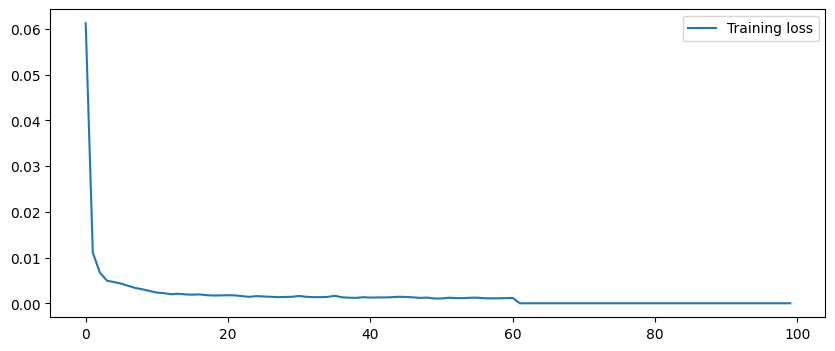

In [46]:
# epoch별 손실값
fig = plt.figure(figsize=(10, 4))
plt.plot(train_hist, label="Training loss")
plt.legend()
plt.show()

In [47]:
# 예측 테스트
with torch.no_grad(): 
    pred = []
    for pr in range(len(testX_tensor)):

        test_sample = testX_tensor[pr].to(device)
        model.reset_hidden_state()

        predicted = model(torch.unsqueeze(test_sample, 0))
        predicted = torch.flatten(predicted).item()
        pred.append(predicted)

    # INVERSE
    pred_inverse = scaler.inverse_transform(np.array(pred).reshape(-1, 1))
    testY_inverse = scaler.inverse_transform(testY_tensor)

def MAE(true, pred):
    return np.mean(np.abs(true-pred))

print('MAE SCORE : ', MAE(pred_inverse, testY_inverse))

ValueError: non-broadcastable output operand with shape (1752,1) doesn't match the broadcast shape (1752,206)

#### price 예측 (random forest)

In [169]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

In [60]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2,shuffle=False, random_state=42)

# 모델 훈련a
model = RandomForestRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = RandomForestRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

Mean Squared Error on Validation Set: 3.5972101768308447


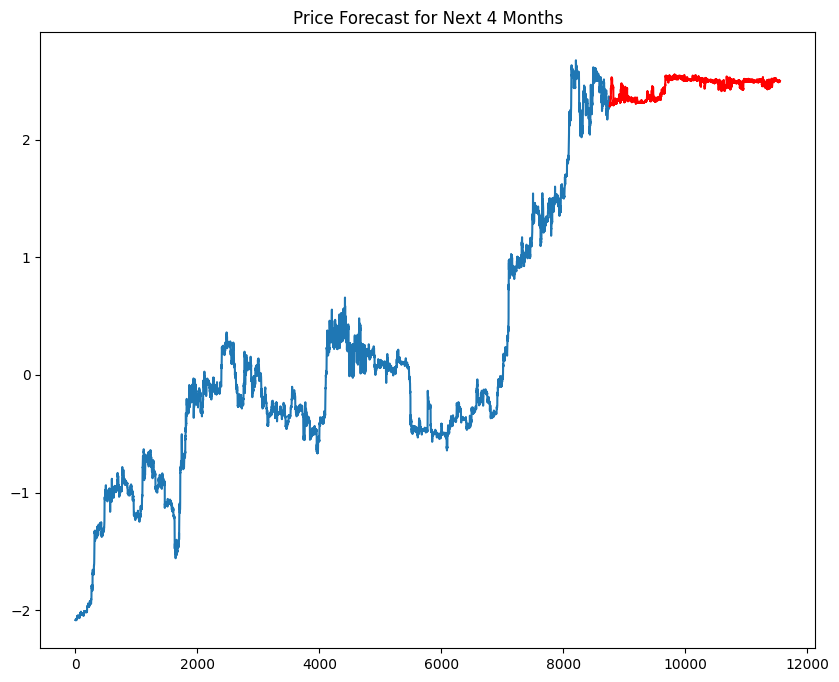

In [61]:
pred_df = pd.DataFrame(y_pred)

forecast_step = 2880

plt.figure(figsize=(10,8))
plt.plot(y_train, label='Historical Data')
plt.plot(range(y_train.index[-1]+1, y_train.index[-1]+1 + len(y_pred)), pred_df, label='Forecast', color='red')
plt.title('Price Forecast for Next 4 Months')
plt.show()

In [170]:
# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

# 결과 확인
std_test_df.head(3)

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_fees-transaction_fees_transaction_mean,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
8760,2024-01-01 00:00:00,NaN,test,0.862267,0.047456,-0.368791,1.123435,-1.106685,0.628514,3.492500,...,-0.281419,0.622390,3.599144,-1.275562,1.945012,2.242378,-0.289134,-0.228944,-0.293700,-0.223232
8761,2024-01-01 01:00:00,NaN,test,1.129189,0.106802,-0.359145,1.203588,-1.186934,0.709193,1.236332,...,-0.281769,1.514263,3.687307,-0.856214,4.171627,4.675388,-0.285791,-0.137437,-0.288604,-0.090258
8762,2024-01-01 02:00:00,NaN,test,1.435859,-0.671125,-0.671636,-0.004335,0.022434,-0.173300,0.990473,...,-0.100861,-0.200075,3.704422,-0.958328,2.247406,2.580664,0.231648,-0.235255,0.500278,-0.232367


#### price 예측 - xgboost

In [21]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, shuffle = False, test_size=0.2, random_state=42)

# 모델 훈련a
model = xgb.XGBRegressor()
model.fit(X_train_split, y_train_split)

# 검증 데이터에서 예측
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = xgb.XGBRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

Mean Squared Error on Validation Set: 3.4032119042308335


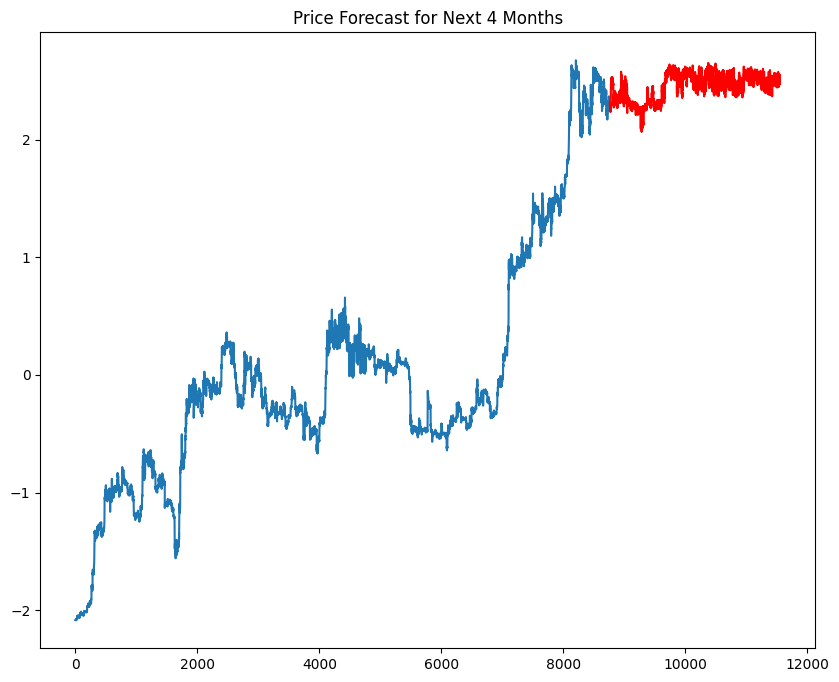

In [17]:
pred_df = pd.DataFrame(y_pred)

forecast_step = 2880

plt.figure(figsize=(10,8))
plt.plot(y_train, label='Historical Data')
plt.plot(range(y_train.index[-1]+1, y_train.index[-1]+1 + len(y_pred)), pred_df, label='Forecast', color='red')
plt.title('Price Forecast for Next 4 Months')
plt.show()

#### price 예측 - lgbm

In [27]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.2, random_state=42)

# lgb dataset
train_data = lgb.Dataset(X_train_split, label=y_train_split)
valid_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

params = {
    "boosting_type": "gbdt", # gbdt, dart, rf
}

# 모델 훈련a
lgb_model = lgb.train(
    params = params,
    train_set=train_data,
    valid_sets=valid_data,
)
y_val_pred = model.predict(X_val)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = lgb.LGBMRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.005310 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 49471
[LightGBM] [Info] Number of data points in the train set: 7008, number of used features: 205
[LightGBM] [Info] Start training from score -0.408506
Mean Squared Error on Validation Set: 8.995708516277786e-05
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007392 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 50459
[LightGBM] [Info] Number of data points in the train set: 8760, number of used features: 205
[LightGBM] [Info] Start training from score 0.000000


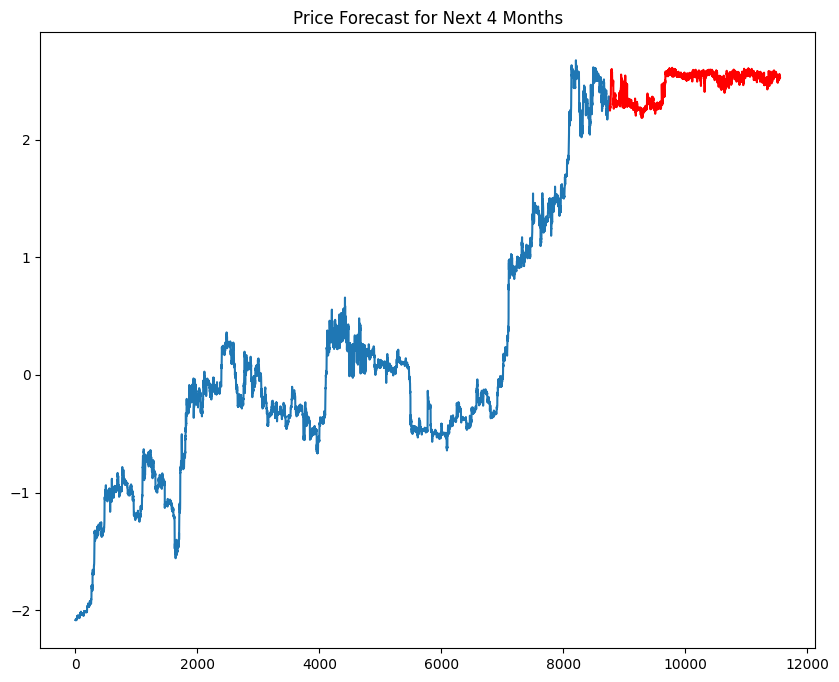

In [28]:
pred_df = pd.DataFrame(y_pred)

forecast_step = 2880

plt.figure(figsize=(10,8))
plt.plot(y_train, label='Historical Data')
plt.plot(range(y_train.index[-1]+1, y_train.index[-1]+1 + len(y_pred)), pred_df, label='Forecast', color='red')
plt.title('Price Forecast for Next 4 Months')
plt.show()

#### price 예측 - catboost

In [31]:
# 타겟과 피처 설정
y_train = std_train_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']
X_train = std_train_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')

# 훈련 데이터와 검증 데이터 나누기
X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)


# 모델 훈련a
model = cb.CatBoostRegressor()
model.fit(X_train_split, y_train_split)

# 성능 평가
mse = mean_squared_error(y_val, y_val_pred)
print("Mean Squared Error on Validation Set:", mse)

# 모델 훈련
model = cb.CatBoostRegressor()
model.fit(X_train, y_train)

# test_df에서 예측
X_test = std_test_df.drop(columns=['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close', 'ID', 'target', '_type'], errors='ignore')
y_pred = model.predict(X_test)

Learning rate set to 0.055691
0:	learn: 0.9463472	total: 16.5ms	remaining: 16.5s
1:	learn: 0.8985673	total: 27.2ms	remaining: 13.6s
2:	learn: 0.8541858	total: 37.8ms	remaining: 12.6s
3:	learn: 0.8119074	total: 48.3ms	remaining: 12s
4:	learn: 0.7722149	total: 59.2ms	remaining: 11.8s
5:	learn: 0.7333623	total: 69.5ms	remaining: 11.5s
6:	learn: 0.6964389	total: 80.4ms	remaining: 11.4s
7:	learn: 0.6622742	total: 90.9ms	remaining: 11.3s
8:	learn: 0.6289873	total: 102ms	remaining: 11.2s
9:	learn: 0.5986234	total: 112ms	remaining: 11.1s
10:	learn: 0.5696916	total: 123ms	remaining: 11s
11:	learn: 0.5431752	total: 134ms	remaining: 11s
12:	learn: 0.5168727	total: 144ms	remaining: 11s
13:	learn: 0.4915749	total: 155ms	remaining: 10.9s
14:	learn: 0.4679262	total: 165ms	remaining: 10.9s
15:	learn: 0.4461144	total: 177ms	remaining: 10.9s
16:	learn: 0.4249009	total: 187ms	remaining: 10.8s
17:	learn: 0.4049448	total: 198ms	remaining: 10.8s
18:	learn: 0.3861605	total: 208ms	remaining: 10.8s
19:	learn: 

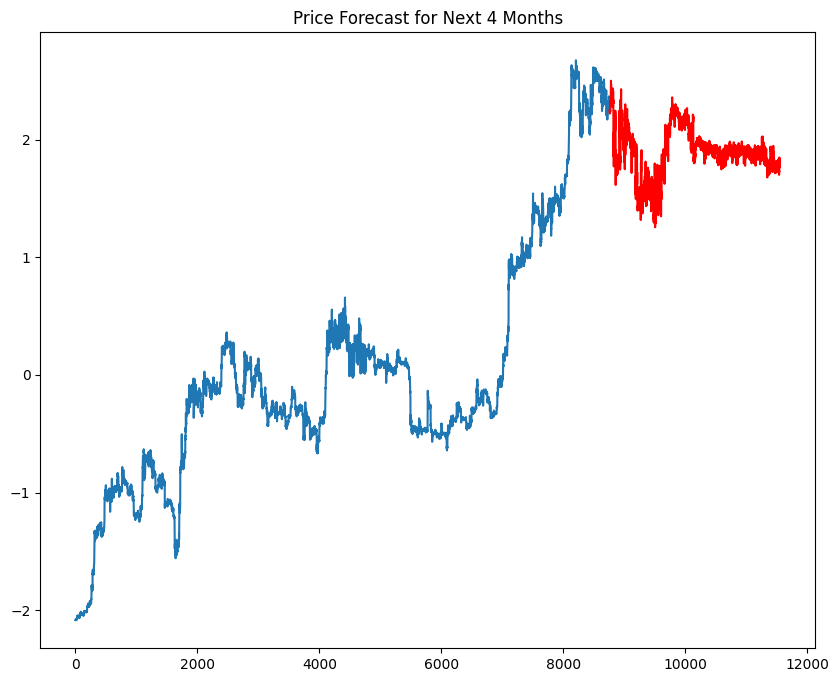

In [32]:
pred_df = pd.DataFrame(y_pred)

forecast_step = 2880

plt.figure(figsize=(10,8))
plt.plot(y_train, label='Historical Data')
plt.plot(range(y_train.index[-1]+1, y_train.index[-1]+1 + len(y_pred)), pred_df, label='Forecast', color='red')
plt.title('Price Forecast for Next 4 Months')
plt.show()

In [34]:
pred_df.shape[0]

2792

In [177]:
# new_test_df에 y_pred 값을 추가
std_test_df['hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'] = y_pred

# 결과 확인
std_test_df.head(3)

,ID,target,_type,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_volume,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_sell_ratio,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_sell_ratio,hourly_network-data_fees-transaction_fees_transaction_mean,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
8760,2024-01-01 00:00:00,NaN,test,0.862267,0.047456,-0.368791,1.123435,-1.106685,0.628514,3.492500,...,-0.281419,0.622390,3.599144,-1.275562,1.945012,2.242378,-0.289134,-0.228944,-0.293700,-0.223232
8761,2024-01-01 01:00:00,NaN,test,1.129189,0.106802,-0.359145,1.203588,-1.186934,0.709193,1.236332,...,-0.281769,1.514263,3.687307,-0.856214,4.171627,4.675388,-0.285791,-0.137437,-0.288604,-0.090258
8762,2024-01-01 02:00:00,NaN,test,1.435859,-0.671125,-0.671636,-0.004335,0.022434,-0.173300,0.990473,...,-0.100861,-0.200075,3.704422,-0.958328,2.247406,2.580664,0.231648,-0.235255,0.500278,-0.232367


#### feature engineering

In [151]:
a = std_train_df.filter(like='all_exchange')
a.columns

Index(['hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations',
       'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd',
       'hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd',
       'hourly_market-data_open-interest_all_exchange_all_symbol_open_interest',
       'hourly_market-data_funding-rates_all_exchange_funding_rates',
       'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume',
       'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume',
       'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio',
       'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio',
       'hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio',
       'hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations',
       'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close'],
      dtype='object')

In [171]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close" : "close",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 9)

In [172]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    close_diff = df['close'].diff().fillna(0),
    close_diffg = np.sign(df['close'].diff().fillna(0))
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg",  "volume_diffg", "close_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["close","ID", "target", "_type"]] + [
    "liquidation_diff",
    "volume_diff",
    "close_diff"
]

In [173]:
df = df.drop(columns = 'close', axis=1)
df.head(3)

,ID,target,_type,funding_rates,long_liquidations,short_liquidations,buy_volume,sell_volume,liquidation_diff,volume_diff,liquidation_diffg,volume_diffg,close_diff,close_diffg
0,2023-01-01 00:00:00,2.0,train,0.005049,0.012,0.000,4.648309e+07,5.137537e+07,0.012,-4.892284e+06,1.0,-1.0,0.000000,0.0
1,2023-01-01 01:00:00,1.0,train,0.005049,0.000,0.712,3.975599e+07,2.401129e+07,-0.712,1.574470e+07,-1.0,1.0,20.388568,1.0
2,2023-01-01 02:00:00,1.0,train,0.005049,0.000,0.000,2.405402e+07,2.340995e+07,0.000,6.440658e+05,0.0,1.0,-8.986731,-1.0


In [174]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 72)]
)

In [175]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

#### model training

In [176]:
# train_test_split 으로 valid set, train set 분리
x_train, x_valid, y_train, y_valid = train_test_split(
    train_df.drop(["target", "ID"], axis = 1), 
    train_df["target"].astype(int), 
    test_size=0.2,
    random_state=42,
)

# lgb dataset
train_data = lgb.Dataset(x_train, label=y_train)
valid_data = lgb.Dataset(x_valid, label=y_valid, reference=train_data)

# lgb params
params = {
    "boosting_type": "dart",
    "objective": "multiclass",
    "metric": "multi_logloss",
    "num_class": 4,
    "num_leaves": 50,
    "learning_rate": 0.05,
    "n_estimators": 30,
    "random_state": 42,
    "verbose": 0,
}

# lgb train
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
    valid_sets=valid_data,
)

# lgb predict
y_valid_pred = lgb_model.predict(x_valid)
y_valid_pred_class = np.argmax(y_valid_pred, axis = 1)

# score check
accuracy = accuracy_score(y_valid, y_valid_pred_class)
auroc = roc_auc_score(y_valid, y_valid_pred, multi_class="ovr")

print(f"acc: {accuracy}, auroc: {auroc}")

acc: 0.464041095890411, auroc: 0.6523404220414


In [177]:
# performance 체크후 전체 학습 데이터로 다시 재학습
x_train = train_df.drop(["target", "ID"], axis = 1)
y_train = train_df["target"].astype(int)
train_data = lgb.Dataset(x_train, label=y_train)
lgb_model = lgb.train(
    params=params,
    train_set=train_data,
)

In [178]:
f_i = lgb_model.feature_importance()

In [181]:
f_i_df = pd.DataFrame({'feature' : x_train.columns, 'importance' :f_i})
f_i_df = f_i_df.sort_values(by = 'importance')
f_i_df.loc[f_i_df['importance'] == 0]

,feature,importance
32,funding_rates_22,0
57,funding_rates_47,0
56,funding_rates_46,0
320,sell_volume_26,0
7,liquidation_diffg,0
8,volume_diffg,0
10,close_diffg,0
35,funding_rates_25,0


In [182]:
f_i_df

,feature,importance
32,funding_rates_22,0
57,funding_rates_47,0
56,funding_rates_46,0
320,sell_volume_26,0
7,liquidation_diffg,0
...,...,...
508,close_diff_1,51
6,volume_diff,59
4,sell_volume,67
3,buy_volume,79


In [183]:
# lgb predict
y_test_pred = lgb_model.predict(test_df.drop(["target", "ID"], axis = 1))
y_test_pred_class = np.argmax(y_test_pred, axis = 1)

In [184]:
# output file 할당후 save 
submission_df = submission_df.assign(target = y_test_pred_class)
submission_df.to_csv("output_0926.csv", index=False)